In [21]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score # K折交叉验证模块
from sklearn.preprocessing import MinMaxScaler

import QUANTAXIS as QA
import pandas as pd
import numpy as np
import pyecharts
import talib

#设定绘图的默认大小
import matplotlib
matplotlib.rcParams["figure.figsize"]=[16,5]

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Noto Sans CJK SC','SimHei']
matplotlib.rcParams['axes.unicode_minus']=False #用来正常显示负号

#加载 seaborn，并且设置默认使用 seaborn
import seaborn as sns
sns.set(font=['Noto Sans CJK SC','SimHei'])

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [22]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor

In [23]:
stock_code='601398'
benchmark_code='399300'
start_time='2005-01-01'
end_time='2018-12-31'

In [24]:
data_raw=QA.QA_fetch_stock_day_adv(stock_code, start_time, end_time).to_qfq().data.reset_index().set_index('date')
data_raw.head(1)

,code,open,high,low,close,volume,amount,preclose,adj
date,,,,,,,,,
2006-10-27,601398,1.992133,2.01557,1.910104,1.921823,4.407654e+07,8.725310e+09,NaN,0.585922


# 方法定义

In [74]:
def normalize_data(df):
    """数据归一化"""
    return df / df.iloc[0]


def min_max_sclar(df):
    columns=list(df.columns)
    s = MinMaxScaler().fit_transform(df[columns])
    return pd.DataFrame(s, columns=columns, index=df.index)

def create_valid_data(df,days,column='close')->pd.DataFrame:
    '''根据 `df` 中的 `column` 列，制作新的数据。
    取 `days` 天后的 `column` 列数据。
    '''
    result={}
    if column not in df.columns:
        raise ValueError('数据中不包含 {} 列。'.format(column))
    df_copy=df.copy()
    df_copy[days]=df_copy.shift(days*-1)[column]
    return df_copy[[days]].dropna()

def create_validate_data_1(df,days,column='close')->pd.DataFrame:
    '''根据 `df` 中的 `column` 列，制作新的数据。
    根据参数 `days` 增加列，有多少days增加多少列，每一列对应了当前日期后第几天的 `column` 数据
    '''
    if column not in df.columns:
        raise ValueError('数据中不包含 {} 列。'.format(column))
    df_copy = df.copy()
    for i in range(1, days + 1):
        df_copy[i] = df_copy.shift(i * -1)[column]
    return df_copy[[i for i in range(1, days + 1)]].dropna()

def do_predict_1(func,X,y,days):
    """对X的数据进行 predict ,y的格式为 `create_validate_data_1` 创建的多列格式"""
    v=pd.DataFrame(func.predict(X),columns=['预测值_{}'.format(i) for i in range(1,days+1)],index=X.index)
    y_new=y.rename(columns=lambda x: '实际值_{}'.format(x))
    return np.round(v.join(y_new).join(X[['close']].rename(columns={'close':'收盘价'})).sort_index(),2)

def plot_1(df,days):
    c=['预测值_{}'.format(i) for i in range(1,days+1)]+['实际值_{}'.format(i) for i in range(1,days+1)]
    return df[c].plot(figsize=(15,5))

def create_xy(data:pd.DataFrame,append:pd.DataFrame,days,reserve_cols=['close','high','low','open'],create_valid_data_func=create_valid_data):
    """获取X,y数据
    Args:
    data: 原始数据
    append: 需要附加的数据。例如计算后的BBands等
    reserve_cols： 原始数据中需要保留的列
    create_valid_data_func: 创建测试数据需要用到的方法定义
    kwargs: 除data外其他`create_valid_data_func`需要用到的数据
    """
    y=create_valid_data_func(data,days)
    X=data[reserve_cols]
    X=X.join(append)
    y_cols=y.columns
    X=np.round(X,2)
    y=np.round(y,2)
    d=X.join(y).dropna()
    return d.drop(columns=y_cols),d[y_cols]

In [26]:
data=data_raw.copy()

In [27]:
data.head()

,code,open,high,low,close,volume,amount,preclose,adj
date,,,,,,,,,
2006-10-27,601398,1.992133,2.015570,1.910104,1.921823,4.407654e+07,8.725310e+09,NaN,0.585922
2006-10-30,601398,1.915963,1.945260,1.904245,1.927682,6.006282e+06,1.153128e+09,1.921823,0.585922
2006-10-31,601398,1.921823,1.951119,1.921823,1.933541,3.927594e+06,7.610508e+08,1.927682,0.585922
2006-11-01,601398,1.933541,1.939400,1.921823,1.933541,2.268092e+06,4.372648e+08,1.933541,0.585922
2006-11-02,601398,1.933541,1.933541,1.904245,1.921823,2.989400e+06,5.733994e+08,1.933541,0.585922


创建5日后的收盘价与当日收盘价的变化率为结果集。

结果集列命名为当前计算的日期数量。下面是5.

将X，y数据合并后dropna()，之后再拆分为X，y。

X为**ASI**计算后的数据。

In [28]:
from sklearn.model_selection import cross_val_score # K折交叉验证模块
warnings.filterwarnings('ignore')

def cross_validate(X,y,test_size=0.2,random_state=10,funcs={'DecisionTreeRegressor':DecisionTreeRegressor(),
       'LinearRegression':LinearRegression(),
       'SVR':SVR(),
       'KNeighborsRegressor':KNeighborsRegressor(),
       'RandomForestRegressor':RandomForestRegressor(),
       'AdaBoostRegressor':AdaBoostRegressor(),
       'GradientBoostingRegressor':GradientBoostingRegressor(),
       'BaggingRegressor':BaggingRegressor(),
       'ExtraTreeRegressor':ExtraTreeRegressor()
      },cv=30):

    # 拆分数据源
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=test_size,
                                                            random_state=random_state)
    cross_validation_report=[]

    for k,v in funcs.items():
        try:
            v.fit(X_train, y_train)
            model_score=v.score(X_test, y_test)
            #使用K折交叉验证模块
            scores = cross_val_score(v, X, y, cv=cv)
            #将5次的预测准确平均率打印出
            cross_score=scores.mean()
            cross_validation_report.append([k,model_score,cross_score])
        except Exception as ex:
            print('{0} {1}'.format(k,ex))
            continue
    return pd.DataFrame(cross_validation_report,columns=['name','model_score','cross_score']).sort_values('cross_score',ascending=False)

def do_fit(X,y,test_size=0.2,random_state=10,func=LinearRegression):
    
    # 拆分数据源
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=test_size,
                                                            random_state=random_state)
    f=func()
    f.fit(X_train,y_train)
    return f,X_train, X_test, y_train, y_test

# 测算开始

## n天后的单一数据

### ASI指标计算

In [29]:
append_data = min_max_sclar(
    QA.QA_indicator_ASI(data)
    )
X, y = create_xy(data, append_data, days=5,reserve_cols=['close'])
cross_validate(X, y)

,name,model_score,cross_score
4,LinearRegression,0.975312,0.509931
1,SVR,0.976227,0.430040
7,GradientBoostingRegressor,0.977361,0.343299
3,RandomForestRegressor,0.979558,0.122344
0,BaggingRegressor,0.980655,0.097205
6,KNeighborsRegressor,0.980088,0.078089
8,AdaBoostRegressor,0.962357,-0.309527
5,DecisionTreeRegressor,0.969229,-0.568615
2,ExtraTreeRegressor,0.966133,-0.614534


### ASI+OBV

In [30]:
append_data = min_max_sclar(
    QA.QA_indicator_ASI(data)
    .join(QA.QA_indicator_OBV(data))
    )
X, y = create_xy(data, append_data, days=5,reserve_cols=['close'])
cross_validate(X, y)

,name,model_score,cross_score
4,LinearRegression,0.975286,0.505424
1,SVR,0.977019,0.446333
7,GradientBoostingRegressor,0.980026,0.369421
3,RandomForestRegressor,0.986488,0.138739
0,BaggingRegressor,0.984470,-0.024465
6,KNeighborsRegressor,0.983586,-0.029176
8,AdaBoostRegressor,0.967009,-0.309241
5,DecisionTreeRegressor,0.979575,-0.606436
2,ExtraTreeRegressor,0.976927,-0.645193


### ASI+OBV+VR

In [31]:
append_data = min_max_sclar(
    QA.QA_indicator_ASI(data)
    .join(QA.QA_indicator_OBV(data))
    .join(QA.QA_indicator_VR(data).drop(columns=['a', 'b']))
    )
X, y = create_xy(data, append_data, days=5,reserve_cols=['close'])
cross_validate(X, y)

,name,model_score,cross_score
4,LinearRegression,0.975298,0.503303
1,SVR,0.977303,0.447313
7,GradientBoostingRegressor,0.980045,0.363927
6,KNeighborsRegressor,0.985077,-0.000707
0,BaggingRegressor,0.985569,-0.008925
3,RandomForestRegressor,0.986724,-0.022846
8,AdaBoostRegressor,0.965351,-0.352155
5,DecisionTreeRegressor,0.972753,-0.584995
2,ExtraTreeRegressor,0.979439,-0.613797


### ASI+OBV+VR+WILLR

In [32]:
append_data = min_max_sclar(
    QA.QA_indicator_ASI(data)
    .join(QA.QA_indicator_OBV(data))
    .join(QA.QA_indicator_VR(data).drop(columns=['a', 'b']))
    .join(QA.QA_indicator_WR(data, 7, 14))
    )
X, y = create_xy(data, append_data, days=5,reserve_cols=['close'])
cross_validate(X, y)

,name,model_score,cross_score
4,LinearRegression,0.975403,0.495589
1,SVR,0.977382,0.448760
7,GradientBoostingRegressor,0.979782,0.350738
6,KNeighborsRegressor,0.980612,0.036049
0,BaggingRegressor,0.985031,-0.043408
3,RandomForestRegressor,0.985295,-0.107472
8,AdaBoostRegressor,0.964941,-0.601050
5,DecisionTreeRegressor,0.972880,-0.821011
2,ExtraTreeRegressor,0.973765,-1.517002


### ASI+OBV+VR+WILLR+EXPMA

In [33]:
append_data = min_max_sclar(
    QA.QA_indicator_ASI(data)
    .join(QA.QA_indicator_OBV(data))
    .join(QA.QA_indicator_VR(data).drop(columns=['a', 'b']))
    .join(QA.QA_indicator_WR(data, 7, 14))
    .join(QA.QA_indicator_EXPMA(data))
    )
X, y = create_xy(data, append_data, days=5,reserve_cols=['close'])
cross_validate(X, y)

,name,model_score,cross_score
4,LinearRegression,0.975840,0.492495
1,SVR,0.976791,0.468884
7,GradientBoostingRegressor,0.980513,0.175096
6,KNeighborsRegressor,0.980427,0.062079
3,RandomForestRegressor,0.981854,-0.245547
8,AdaBoostRegressor,0.968923,-0.290469
0,BaggingRegressor,0.983381,-0.301879
2,ExtraTreeRegressor,0.973940,-0.682485
5,DecisionTreeRegressor,0.976500,-1.163239


### KDJ+RSI+MACD指标组合

In [34]:
append_data = min_max_sclar(
    QA.QA_indicator_KDJ(data)
    .join(QA.QA_indicator_RSI(data))
    .join(QA.QA_indicator_MACD(data, 7, 14))
)
X, y = create_xy(data, append_data, days=5, reserve_cols=['close'])
cross_validate(X, y)

,name,model_score,cross_score
4,LinearRegression,0.977255,0.487875
1,SVR,0.977729,0.454767
7,GradientBoostingRegressor,0.981577,0.373647
0,BaggingRegressor,0.981619,0.090225
3,RandomForestRegressor,0.982956,0.071374
6,KNeighborsRegressor,0.983138,-0.022871
8,AdaBoostRegressor,0.965207,-0.311412
5,DecisionTreeRegressor,0.973872,-0.586323
2,ExtraTreeRegressor,0.969670,-0.821323


### KDJ+DMI指标组合

In [35]:
append_data = min_max_sclar(
    QA.QA_indicator_KDJ(data)
    .join(QA.QA_indicator_DMI(data))
)
X, y = create_xy(data, append_data, days=5, reserve_cols=['close'])
cross_validate(X, y)

,name,model_score,cross_score
4,LinearRegression,0.976702,0.485626
1,SVR,0.977287,0.430391
7,GradientBoostingRegressor,0.977219,0.296602
0,BaggingRegressor,0.978697,0.048497
3,RandomForestRegressor,0.979550,-0.083592
6,KNeighborsRegressor,0.981382,-0.378574
8,AdaBoostRegressor,0.962548,-0.454940
2,ExtraTreeRegressor,0.965354,-1.232098
5,DecisionTreeRegressor,0.962967,-1.343092


### MA+DMI+VOL组合

In [36]:
append_data = min_max_sclar(
    QA.QA_indicator_EMA(data,5)
    .join(QA.QA_indicator_DMI(data))
)
X, y = create_xy(data, append_data, days=5, reserve_cols=['close'])
cross_validate(X, y)

,name,model_score,cross_score
4,LinearRegression,0.977085,0.487489
1,SVR,0.977171,0.427843
7,GradientBoostingRegressor,0.977701,0.322419
3,RandomForestRegressor,0.979220,-0.079796
0,BaggingRegressor,0.978380,-0.141329
6,KNeighborsRegressor,0.979513,-0.192349
8,AdaBoostRegressor,0.964582,-0.358748
5,DecisionTreeRegressor,0.960415,-0.929803
2,ExtraTreeRegressor,0.964395,-1.212693


In [37]:
append_data = min_max_sclar(
    QA.QA_indicator_CHO(data)
    .join(QA.QA_indicator_VR(data))
    .join(QA.QA_indicator_VRSI(data))
#     .join(QA.QA_indicator_CR(data))
    .join(QA.QA_indicator_VSTD(data))
    .join(QA.QA_indicator_OBV(data))
    .join(QA.QA_indicator_VPT(data))
    .join(QA.QA_indicator_MFI(data))
)
X, y = create_xy(data, append_data, days=5, reserve_cols=['close'])
cross_validate(X, y)

,name,model_score,cross_score
4,LinearRegression,0.976955,0.492409
1,SVR,0.977198,0.468085
7,GradientBoostingRegressor,0.978449,0.353865
6,KNeighborsRegressor,0.982521,0.017834
3,RandomForestRegressor,0.981951,-0.078745
0,BaggingRegressor,0.982687,-0.144400
8,AdaBoostRegressor,0.964428,-0.859023
5,DecisionTreeRegressor,0.969193,-1.022195
2,ExtraTreeRegressor,0.966132,-1.079117


## 连续数据

### ASI+佳庆（Chaikin Oscillator）+WILLR

In [38]:
append_data = min_max_sclar(
    QA.QA_indicator_CHO(data)
    .join(QA.QA_indicator_ASI(data))
    .join(QA.QA_indicator_WR(data,3,3)[['WR1']])
)
X, y = create_xy(data, append_data, days=3, reserve_cols=['close'],create_valid_data_func=create_validate_data_1)
cross_validate(X, y)

SVR bad input shape (2324, 3)
GradientBoostingRegressor bad input shape (2324, 3)
AdaBoostRegressor bad input shape (2324, 3)


,name,model_score,cross_score
3,LinearRegression,0.990482,0.791467
5,KNeighborsRegressor,0.990362,0.651390
2,RandomForestRegressor,0.990549,0.647360
0,BaggingRegressor,0.991334,0.644165
1,ExtraTreeRegressor,0.981964,0.319284
4,DecisionTreeRegressor,0.985997,0.283086


### 多指标

#### 趋向指标 又叫趋势跟踪类指标,主要用于跟踪并预测股价的发展趋势

    1. 趋向指标 DMI

        由於DMI指標主要的用途在於作趨勢成立的判斷，因此是屬於較為**長期**交易的技術指標。而DMI指標的三條線中，ADX線可以說是相當奇特的一條線。ADX線在上昇趨勢開始形成時，會從底部往上攀昇，直到上昇趨勢開始平緩而盤旋時，ADX線便回轉向下。而當下降趨勢開始時，ADX線同樣的又開始從底部往上爬昇，直到下降趨勢和緩而盤整時，ADX線又開始向下回轉。
        https://www.moneydj.com/KMDJ/Wiki/WikiViewer.aspx?KeyID=e1141d5c-ba75-4217-8f70-c96ed11c5c57

    2. 简单移动平均（英语：simple moving average，SMA）
    3. 指数移动平均（英语：exponential moving average，EMA或EXMA）

        是以指数式递减加权的移动平均。各数值的加权影响力随时间而指数式递减，越近期的数据加权影响力越重，但较旧的数据也给予一定的加权值。
        
        https://wiki.mbalib.com/wiki/EXPMA
    4. 瀑布线 PBX

        瀑布线是由均线系统优化得来的趋势性指标。瀑布线属于传统大**纯价格趋势线**，它的真正名称叫做非线性加权移动平均线。瀑布线是一种中线指标，一般用来研究股价的**中期**走势。
        
        https://wiki.mbalib.com/wiki/%E7%80%91%E5%B8%83%E7%BA%BF

    5. DMA指标（Different of Moving Average）

        又叫平行线差指标，是目前股市分析技术指标中的一种**中短期**指标，它常用于大盘指数和个股的研判。
        
        https://wiki.mbalib.com/wiki/DMA

    5. 动量指标（Momentom Index）MTM

        动量指标又叫MTM指标，其英文全称是“Momentom Index”，是一种专门研究股价波动的**中短期**技术分析工具。
        
        https://wiki.mbalib.com/wiki/MTM

    5. 佳庆指标（Chaikin Oscillator）CHO

        以能量潮指标（OBV）为例子。如果当日股价上涨，则当日所有的成交量总额，一律视为多头动能。如果当日股价下跌，则当日所有成交量总额，一律视为空头动能。这种论点太过于简化，而且不符合实际的现状。一段完整的趋势行情，会发生很多次重要的短、中期头部和底部，然而，OBV指标主要是针对极端的行情起作用。也就是说，只有在成交量极度萎缩或极度扩张的状况下，OBV指标才能发挥作用。

        拉瑞·威廉将OBV加以改良，用来决定当日的成交量，属于多方或空方力道。OBV以当日的收盘价和前一日的收盘价比较。然而，拉瑞·威廉却以当日收盘价和当日开盘价比较，并且设计了一条累积能量线。如果收盘价高于开盘价，则开盘价距收盘价之间的上涨幅度，以正值百分比表示，并乘以当日成交量。如果收盘价低于开盘价，则开盘价距收盘价之间的下跌幅度，以负值百分比表示，再乘以当日成交量。经过这样的改良之后，其侦测量价背离的功能，显然更具有参考价值。
        
        https://wiki.mbalib.com/wiki/%E4%BD%B3%E5%BA%86%E6%8C%87%E6%A0%87

In [39]:
append_data = min_max_sclar(
    QA.QA_indicator_DMI(data,5,2)
    .join(QA.QA_indicator_EMA(data,3))
    .join(QA.QA_indicator_PBX(data))
    .join(QA.QA_indicator_DMA(data))
    .join(QA.QA_indicator_MTM(data,6,3))
    .join(QA.QA_indicator_CHO(data,6,3))
)
X, y = create_xy(data, append_data, days=3, reserve_cols=['close'],create_valid_data_func=create_validate_data_1)
cross_validate(X, y)

SVR bad input shape (2276, 3)
GradientBoostingRegressor bad input shape (2276, 3)
AdaBoostRegressor bad input shape (2276, 3)


,name,model_score,cross_score
3,LinearRegression,0.989623,0.729469
2,RandomForestRegressor,0.990870,0.480103
0,BaggingRegressor,0.990607,0.476363
5,KNeighborsRegressor,0.989028,0.306219
1,ExtraTreeRegressor,0.985583,-0.005982
4,DecisionTreeRegressor,0.985995,-0.018888


反趋向指标
主要捕捉趋势的转折点
随机指标KDJ
乖离率 BIAS
变动速率 ROC
顺势指标 CCI
威廉指标 W&R
震荡量(变动速率) OSC
相对强弱指标 RSI
动态买卖指标 ADTM

In [40]:
append_data = min_max_sclar(
    QA.QA_indicator_KDJ(data)
    .join(QA.QA_indicator_BIAS(data,3,3,3)[['BIAS1']])#'乖离率'
    .join(QA.QA_indicator_ROC(data))
    .join(QA.QA_indicator_CCI(data))
    .join(QA.QA_indicator_WR(data,3,3)[['WR1']])
    .join(QA.QA_indicator_OSC(data))
    .join(QA.QA_indicator_RSI(data))
    .join(QA.QA_indicator_ADTM(data))
)
X, y = create_xy(data, append_data, days=3, reserve_cols=['close'],create_valid_data_func=create_validate_data_1)
cross_validate(X, y)

SVR bad input shape (2328, 3)
GradientBoostingRegressor bad input shape (2328, 3)
AdaBoostRegressor bad input shape (2328, 3)


,name,model_score,cross_score
3,LinearRegression,0.989930,0.777040
2,RandomForestRegressor,0.989366,0.626532
0,BaggingRegressor,0.988966,0.621114
4,DecisionTreeRegressor,0.981698,0.163544
5,KNeighborsRegressor,0.986692,0.135056
1,ExtraTreeRegressor,0.978700,-0.162597


量能指标
通过成交量的大小和变化研判趋势变化
容量指标 VR
量相对强弱 VRSI
能量指标 CR
人气意愿指标 ARBR
成交量标准差 VSTD"""

In [41]:
append_data = min_max_sclar(
    QA.QA_indicator_VR(data)
    .join(QA.QA_indicator_VRSI(data))
#     .join(QA.QA_indicator_CR(data))
#     .join(QA.QA_indicator_ARBR(data))
    .join(QA.QA_indicator_VSTD(data))
)
X, y = create_xy(data, append_data, days=3, reserve_cols=['close'],create_valid_data_func=create_validate_data_1)
cross_validate(X, y)

SVR bad input shape (2332, 3)
GradientBoostingRegressor bad input shape (2332, 3)
AdaBoostRegressor bad input shape (2332, 3)


,name,model_score,cross_score
3,LinearRegression,0.991236,0.790143
2,RandomForestRegressor,0.990350,0.628511
0,BaggingRegressor,0.989221,0.622518
5,KNeighborsRegressor,0.989570,0.609943
1,ExtraTreeRegressor,0.980874,0.240817
4,DecisionTreeRegressor,0.982695,0.224355


量价指标
通过成交量和股价变动关系分析未来趋势
震荡升降指标ASI
价量趋势PVT
能量潮OBV
量价趋势VPT

In [48]:
append_data = min_max_sclar(
    QA.QA_indicator_ASI(data)
    .join(QA.QA_indicator_PVT(data))
    .join(QA.QA_indicator_OBV(data))
    .join(QA.QA_indicator_VPT(data))
)
X, y = create_xy(data, append_data, days=3, reserve_cols=['close'],create_valid_data_func=create_validate_data_1)
cross_validate(X, y)

SVR bad input shape (2324, 3)
GradientBoostingRegressor bad input shape (2324, 3)
AdaBoostRegressor bad input shape (2324, 3)


,name,model_score,cross_score
3,LinearRegression,0.990482,0.791020
0,BaggingRegressor,0.991470,0.612837
2,RandomForestRegressor,0.991478,0.608356
5,KNeighborsRegressor,0.991886,0.593720
1,ExtraTreeRegressor,0.984603,0.385485
4,DecisionTreeRegressor,0.987312,0.309742


全部指标

In [60]:
append_data = min_max_sclar(
    QA.QA_indicator_DMI(data,5,2)
    .join(QA.QA_indicator_EMA(data,3))
    .join(QA.QA_indicator_PBX(data))
    .join(QA.QA_indicator_DMA(data))
    .join(QA.QA_indicator_MTM(data,6,3))
    .join(QA.QA_indicator_CHO(data,6,3))
    .join(QA.QA_indicator_KDJ(data))
    .join(QA.QA_indicator_BIAS(data,3,3,3)[['BIAS1']])#'乖离率'
    .join(QA.QA_indicator_ROC(data))
    .join(QA.QA_indicator_CCI(data))
    .join(QA.QA_indicator_WR(data,3,3)[['WR1']])
    .join(QA.QA_indicator_OSC(data))
    .join(QA.QA_indicator_RSI(data))
    .join(QA.QA_indicator_ADTM(data))
    .join(QA.QA_indicator_VR(data).drop(columns=['a', 'b']))
    .join(QA.QA_indicator_VRSI(data))
    .join(QA.QA_indicator_VSTD(data))
    .join(QA.QA_indicator_ASI(data))
    .join(QA.QA_indicator_PVT(data))
    .join(QA.QA_indicator_OBV(data))
    .join(QA.QA_indicator_VPT(data))
)
X, y = create_xy(data, append_data, days=3, reserve_cols=['close'],create_valid_data_func=create_validate_data_1)
cross_validate(X, y)

SVR bad input shape (2276, 3)
GradientBoostingRegressor bad input shape (2276, 3)
AdaBoostRegressor bad input shape (2276, 3)


,name,model_score,cross_score
3,LinearRegression,0.989565,0.700213
2,RandomForestRegressor,0.991684,0.505594
0,BaggingRegressor,0.991609,0.490328
1,ExtraTreeRegressor,0.987736,-0.171757
4,DecisionTreeRegressor,0.985842,-0.232938
5,KNeighborsRegressor,0.987002,-0.543698


In [77]:
func,X_train, X_test, y_train, y_test=do_fit(X,y,func=LinearRegression)
do_predict_1(func,X[-30:],y[-30:],3).head()

,预测值_1,预测值_2,预测值_3,实际值_1,实际值_2,实际值_3,收盘价
date,,,,,,,
2018-11-14,5.32,5.33,5.34,5.35,5.34,5.41,5.31
2018-11-15,5.36,5.36,5.37,5.34,5.41,5.35,5.35
2018-11-16,5.33,5.30,5.30,5.41,5.35,5.36,5.34
2018-11-19,5.39,5.36,5.35,5.35,5.36,5.36,5.41
2018-11-20,5.34,5.34,5.34,5.36,5.36,5.33,5.35


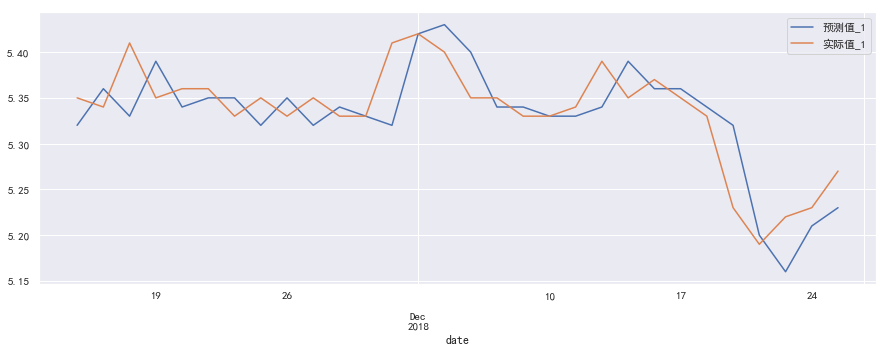

In [79]:
plot_1(do_predict_1(func,X[-30:],y[-30:],3),1)